In [16]:
import numpy as np
import cv2
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    Concatenate,
    MaxPool2D,
    Dropout,
    Flatten,
)

In [17]:
#import data

# imgs0 = np.load('data/imgs_0.npy')
# vels0 = np.load('data/vels_0.npy')
imgs1 = np.load('data/imgs_900.npy')
vels1 = np.load('data/vels_900.npy')
imgs2 = np.load('data/imgs_900_2.npy')
vels2 = np.load('data/vels_900_2.npy')


imgsf1 = np.load('data/fine_imgs1.npy')
velsf1 = np.load('data/fine_vels1.npy')
imgsf2 = np.load('data/fine_imgs2.npy')
velsf2 = np.load('data/fine_vels2.npy')
imgsf3 = np.load('data/fine_imgs3.npy')
velsf3 = np.load('data/fine_vels3.npy')
# imgsf4 = np.load('data/fine_imgs_4.npy')
# velsf4 = np.load('data/fine_vels_4.npy')
# imgsf5 = np.load('data/fine_imgs_5.npy')
# velsf5 = np.load('data/fine_vels_5.npy')
imgs = np.concatenate([imgs1, imgs2])
vels = np.concatenate([vels1, vels2])
print(imgs.shape)
print(vels.shape)

(41587, 90, 160, 1)
(41587, 2)


In [18]:
# remove the data where the robot is not moving

not_moving = np.where(vels[:, 0] == 0.0)[0]

img_data = np.delete(imgs, not_moving, axis=0)
vel_data = np.delete(vels, not_moving, axis=0)

print(img_data.shape)
print(vel_data.shape)

(41233, 90, 160, 1)
(41233, 2)


In [19]:
# identifying how many data points from each class there are

straight = np.where(vel_data[:, 1] == 0.0)[0]
left = np.where(vel_data[:, 1] == 1.0)[0]
right = np.where(vel_data[:, 1] == -1.0)[0]

straight_img = img_data[straight]
left_img = img_data[left]
right_img = img_data[right]

straight_vel = vel_data[straight]
left_vel = vel_data[left]
right_vel = vel_data[right]

print(straight_img.shape)
print(left_img.shape)
print(right_img.shape)

(23254, 90, 160, 1)
(12330, 90, 160, 1)
(5649, 90, 160, 1)


In [20]:
# reduce the data straight and left data so that there's
# an approximately the same number of data points 

i=np.random.permutation(len(right))
j=np.random.permutation(len(right))

straight_keep = straight[i]
print(straight_keep.shape)
left_keep=left[j]
print(left_keep.shape)
right_keep=right
print(right_keep.shape)
all_keep = np.concatenate([straight_keep, left_keep, right_keep])

(5649,)
(5649,)
(5649,)


In [21]:
img_data = img_data[all_keep]
vel_data=vel_data[all_keep]
print(img_data.shape)
print(vel_data.shape)

(16947, 90, 160, 1)
(16947, 2)


In [22]:
img_data = np.concatenate([img_data, imgsf1, imgsf2, imgsf3])
vel_data = np.concatenate([vel_data, velsf1, velsf2, velsf3])

In [23]:
img_data = img_data/255

In [24]:
velocities_to_actions = {
    (0.25, 0.0): np.array([1, 0, 0]),
    (0.25, 1.0): np.array([0, 1, 0]),
    (0.25, -1.0): np.array([0, 0, 1]),
}

actions = np.array([velocities_to_actions[tuple(i)] for i in vel_data])

In [26]:
input_image = Input(shape=(90, 160, 1))
output_image = Conv2D(32, 4, padding="same")(input_image)
output_image = MaxPool2D(4)(output_image)

# output_image = Conv2D(32, 4, padding="same")(output_image)
# output_image = MaxPool2D(2)(output_image)
# output_image = Dropout(0.5)(output_image)

output_image = Conv2D(16, 4, padding="same")(output_image)
output_image = MaxPool2D(4)(output_image)
output_image = Dropout(0.5)(output_image)

# output_image = Conv2D(16, 4, padding="same")(output_image)
# output_image = MaxPool2D(2)(output_image)
# output_image = Dropout(0.5)(output_image)

output_image = Flatten()(output_image)

output_image = Dense(128, activation="relu")(output_image)
output_image = Dropout(0.5)(output_image)

output_image = Dense(64, activation="relu")(output_image)
output_image = Dropout(0.5)(output_image)

output_image = Dense(32, activation="relu")(output_image)
#output_image = Dropout(0.5)(output_image)

#output_image = Dense(16, activation="relu")(output_image)

output_image = Dense(3, activation="softmax")(output_image)


image_net = Model(input_image, output_image)
image_net.summary()
image_net.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 90, 160, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 160, 32)       544       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 40, 16)        8208      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 10, 16)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 5, 10, 16)         0   

In [27]:
image_net.fit(img_data, actions, batch_size=4, epochs=5, validation_split=0.2)

Epoch 1/5


2023-04-13 00:15:47.253771: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 787219200 exceeds 10% of free system memory.


3417/3417 [==============================] - 47s 14ms/step - loss: 0.5247 - accuracy: 0.7982 - val_loss: 0.5067 - val_accuracy: 0.8086
Epoch 2/5
3417/3417 [==============================] - 59s 17ms/step - loss: 0.3846 - accuracy: 0.8684 - val_loss: 0.5109 - val_accuracy: 0.7989
Epoch 3/5
3417/3417 [==============================] - 50s 15ms/step - loss: 0.3676 - accuracy: 0.8741 - val_loss: 0.5830 - val_accuracy: 0.7826
Epoch 4/5
3417/3417 [==============================] - 51s 15ms/step - loss: 0.3556 - accuracy: 0.8800 - val_loss: 0.4957 - val_accuracy: 0.8147
Epoch 5/5
3417/3417 [==============================] - 50s 15ms/step - loss: 0.3458 - accuracy: 0.8823 - val_loss: 0.5718 - val_accuracy: 0.7785


In [28]:
#image_net.save('/home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/trained_model_inner_loop_finetuned')
#image_net.save('/home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/inner_loop_rm_straight_bias')
image_net.save('/home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/inner_loop_rm_straight_bias_3')

INFO:tensorflow:Assets written to: /home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/inner_loop_rm_straight_bias_3/assets


INFO:tensorflow:Assets written to: /home/fizzer/ros_ws/src/controller_pkg/cnn_trainer/inner_loop_rm_straight_bias_3/assets


In [13]:
imgs0 = np.load('data/imgs_900.npy')
vels0 = np.load('data/vels_900.npy')

not_moving_val = np.where(vels0[:, 0] == 0.0)[0]

img_data_val = np.delete(imgs0, not_moving_val, axis=0)
vel_data_val = np.delete(vels0, not_moving_val, axis=0)

print(img_data_val.shape)
print(vel_data_val.shape)

(20620, 90, 160, 1)
(20620, 2)


In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


y_pred = image_net.predict(img_data_val)
y_test = vel_data_val

645/645 [==============================] - 13s 21ms/step


In [15]:
import matplotlib.pyplot as plt
actions_to_vels = np.array([(0.25, 0.0), (0.25, 1.0), (0.25, -1.0)])

pred=[]

for p in y_pred:
    arr = list(actions_to_vels[np.argmax(p)])
    pred.append(arr)

pred = np.array(pred)
vels_to_classes = {
    (0.25, 0.0): 0,
    (0.25, 1.0): 1,
    (0.25, -1.0): 2,
}

truth =np.array([vels_to_classes[tuple(i)] for i in y_test])
predictions = np.array([vels_to_classes[tuple(i)] for i in pred])

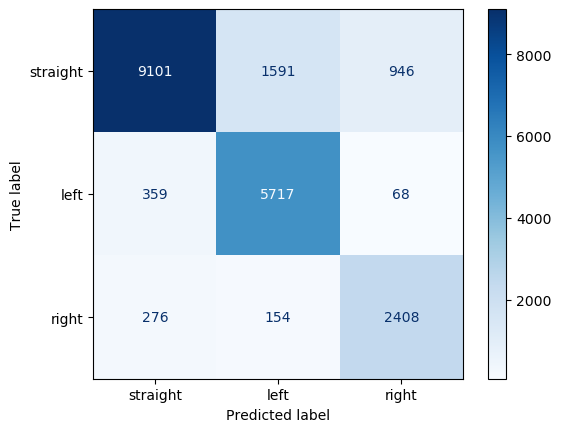

In [16]:
cm = confusion_matrix(truth, predictions)
labels = ['straight', 'left', 'right']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

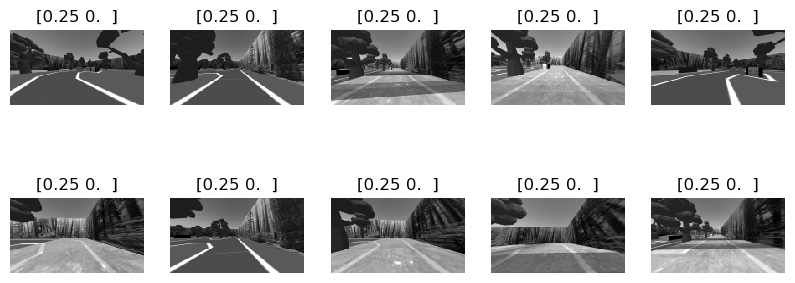

In [46]:
import matplotlib.pyplot as plt
  
# create figure
fig = plt.figure(figsize=(10, 4))
  
# setting values to rows and column variables
rows = 2
columns = 5
  
# reading images
idx = np.random.choice(1000, size=20)
#idx=np.arange(11)
images = img_data[idx]
images = images.squeeze()
#images_plt = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
  
# Adds a subplot at the 1st position

for i in range(1,11):

    fig.add_subplot(rows, columns, i)
    
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.title(str(vel_data[i]))


In [45]:
vel_data[:10]

array([[0.25, 0.  ],
       [0.25, 0.  ],
       [0.25, 0.  ],
       [0.25, 0.  ],
       [0.25, 0.  ],
       [0.25, 0.  ],
       [0.25, 0.  ],
       [0.25, 0.  ],
       [0.25, 0.  ],
       [0.25, 0.  ]])